## Exploring


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)  # show all columns
pd.options.display.float_format = '{:,.2f}'.format

LATEST_DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

def load_dataset(url):
    latest_df = pd.read_csv(url,
                            parse_dates=['Date'],
                            encoding="ISO-8859-1",
                            dtype={"RegionName": str,
                                   "RegionCode": str},
                            error_bad_lines=False)
    latest_df["RegionName"] = latest_df["RegionName"].fillna("")
    return latest_df

df = load_dataset(LATEST_DATA_URL)

In [2]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [3]:
NUM_PREV_DAYS_TO_INCLUDE = 6
WINDOW_SIZE = 7

def get_actual_cases(df, start_date, end_date):
    # 1 day earlier to compute the daily diff
    start_date_for_diff = start_date - pd.offsets.Day(WINDOW_SIZE)
#     actual_df = df[["CountryName", "RegionName", "Date", "ConfirmedCases"]]
    actual_df = df
    # Filter out the data set to include all the data needed to compute the diff
    actual_df = actual_df[(actual_df.Date >= start_date_for_diff) & (actual_df.Date <= end_date)]
    # Add GeoID column that combines CountryName and RegionName for easier manipulation of data
    # np.where usage: if A then B else C
    actual_df["GeoID"] = np.where(actual_df["RegionName"].isnull(),
                                  actual_df["CountryName"],
                                  actual_df["CountryName"] + ' / ' + actual_df["RegionName"])
    actual_df.sort_values(by=["GeoID","Date"], inplace=True)
    # Compute the diff
    actual_df["ActualDailyNewCases"] = actual_df.groupby("GeoID")["ConfirmedCases"].diff().fillna(0)
    # Compute the 7 day moving average
    actual_df["ActualDailyNewCases7DMA"] = actual_df.groupby(
        "GeoID")['ActualDailyNewCases'].rolling(
        WINDOW_SIZE, center=False).mean().reset_index(0, drop=True)
    return actual_df

cleaned_df = get_actual_cases(df=df, 
                              start_date=pd.to_datetime('2020-03-15', format='%Y-%m-%d'), 
                              end_date=pd.to_datetime('2020-12-07', format='%Y-%m-%d'))

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [4]:
cleaned_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,GeoID,ActualDailyNewCases,ActualDailyNewCases7DMA
419,Afghanistan,AFG,,NaN,NAT_TOTAL,2020-03-08,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,3.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,nan,0.00,nan,nan,5.00,0.00,27.78,27.78,34.52,34.52,22.22,22.22,25.64,25.64,0.00,0.00,Afghanistan /,0.00,nan
420,Afghanistan,AFG,,NaN,NAT_TOTAL,2020-03-09,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,3.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,nan,0.00,nan,nan,7.00,0.00,27.78,27.78,34.52,34.52,22.22,22.22,25.64,25.64,0.00,0.00,Afghanistan /,2.00,nan
421,Afghanistan,AFG,,NaN,NAT_TOTAL,2020-03-10,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,3.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,nan,0.00,nan,nan,8.00,0.00,27.78,27.78,34.52,34.52,22.22,22.22,25.64,25.64,0.00,0.00,Afghanistan /,1.00,nan
422,Afghanistan,AFG,,NaN,NAT_TOTAL,2020-03-11,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,3.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,nan,0.00,nan,nan,11.00,0.00,27.78,27.78,34.52,34.52,22.22,22.22,25.64,25.64,0.00,0.00,Afghanistan /,3.00,nan
423,Afghanistan,AFG,,NaN,NAT_TOTAL,2020-03-12,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,3.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,1.00,1.00,"15,000,000.00",0.00,0.00,nan,0.00,nan,nan,12.00,0.00,27.78,27.78,34.52,34.52,22.22,22.22,25.64,25.64,0.00,0.00,Afghanistan /,1.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,Zimbabwe,ZWE,,NaN,NAT_TOTAL,2020-12-03,2.00,0.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,3.00,1.00,0.00,nan,nan,"10,424.00",280.00,69.44,69.44,73.81,73.81,55.56,55.56,60.26,60.26,25.00,25.00,Zimbabwe /,295.00,114.43
98546,Zimbabwe,ZWE,,NaN,NAT_TOTAL,2020-12-04,2.00,0.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,3.00,1.00,0.00,nan,nan,"10,547.00",281.00,69.44,69.44,73.81,73.81,55.56,55.56,60.26,60.26,25.00,25.00,Zimbabwe /,123.00,119.00
98547,Zimbabwe,ZWE,,NaN,NAT_TOTAL,2020-12-05,2.00,0.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,3.00,1.00,0.00,nan,nan,"10,617.00",291.00,69.44,69.44,73.81,73.81,55.56,55.56,60.26,60.26,25.00,25.00,Zimbabwe /,70.00,113.57
98548,Zimbabwe,ZWE,,NaN,NAT_TOTAL,2020-12-06,2.00,0.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,0.00,0.00,3.00,1.00,0.00,nan,nan,"10,718.00",291.00,69.44,69.44,73.81,73.81,55.56,55.56,60.26,60.26,25.00,25.00,Zimbabwe /,101.00,128.00


In [5]:
cdf = (cleaned_df.loc[cleaned_df.GeoID.str.startswith('Canada')]
       .drop(['CountryName', 'RegionName', 'GeoID', 'CountryCode', 'RegionCode'], axis=1)
       .drop(cleaned_df.columns[cleaned_df.columns.str.endswith('ForDisplay')], axis=1)
       .set_index('Date')
      )
cdf

,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,ActualDailyNewCases,ActualDailyNewCases7DMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-08,NAT_TOTAL,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,1.00,0.00,nan,0.00,0.00,0.00,0.00,nan,1.00,1.00,35.00,0.00,0.00,nan,0.00,nan,nan,64.00,0.00,2.78,3.57,7.22,8.33,0.00,0.00,nan
2020-03-09,NAT_TOTAL,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,1.00,0.00,nan,0.00,0.00,0.00,0.00,nan,2.00,1.00,35.00,0.00,0.00,nan,0.00,nan,nan,77.00,1.00,2.78,3.57,9.44,10.90,0.00,13.00,nan
2020-03-10,NAT_TOTAL,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,1.00,0.00,nan,0.00,0.00,0.00,0.00,nan,2.00,1.00,35.00,0.00,0.00,nan,0.00,nan,nan,79.00,1.00,2.78,3.57,9.44,10.90,0.00,2.00,nan
2020-03-11,NAT_TOTAL,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,1.00,0.00,nan,0.00,"11,000,000.00",0.00,2.00,1.00,2.00,1.00,562.00,"200,000,000.00",0.00,nan,0.00,nan,nan,108.00,1.00,13.89,17.86,16.11,18.59,0.00,29.00,nan
2020-03-12,NAT_TOTAL,0.00,nan,0.00,nan,2.00,0.00,0.00,nan,0.00,nan,0.00,nan,0.00,nan,1.00,0.00,nan,0.00,0.00,0.00,2.00,1.00,2.00,1.00,562.00,191.00,0.00,nan,0.00,nan,nan,117.00,1.00,22.22,27.38,21.11,24.36,0.00,9.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-03,STATE_TOTAL,1.00,1.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,1.00,0.00,nan,2.00,1.00,nan,2.00,1.00,1.00,0.00,0.00,2.00,1.00,2.00,2.00,0.00,0.00,3.00,1.00,0.00,nan,nan,50.00,1.00,49.07,63.81,55.56,52.56,75.00,1.00,1.57
2020-12-04,STATE_TOTAL,1.00,1.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,1.00,0.00,nan,2.00,1.00,nan,2.00,1.00,1.00,0.00,0.00,2.00,1.00,2.00,2.00,0.00,0.00,3.00,1.00,0.00,nan,nan,51.00,1.00,49.07,63.81,55.56,52.56,75.00,1.00,1.29
2020-12-05,STATE_TOTAL,1.00,1.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,1.00,0.00,nan,2.00,1.00,nan,2.00,1.00,1.00,0.00,0.00,2.00,1.00,2.00,2.00,0.00,0.00,3.00,1.00,0.00,nan,nan,54.00,1.00,49.07,63.81,55.56,52.56,75.00,3.00,1.29


No handles with labels found to put in legend.


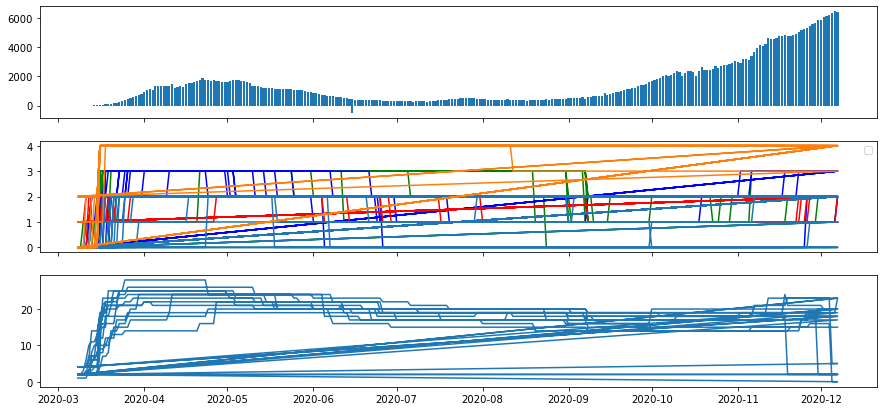

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(15, 7), sharex=True)

axs[0].bar(cdf.index, cdf.ActualDailyNewCases7DMA)
axs[1].plot(cdf[['C1_School closing']], color='g')
axs[1].plot(cdf[['C2_Workplace closing']], color='b')
axs[1].plot(cdf[['C3_Cancel public events']], color='r')
# axs[1].plot(cdf[['C4_Restrictions on gatherings']], color='y')
# axs[1].plot(cdf[['C5_Close public transport']], color='cyan')
# axs[1].plot(cdf[['C6_Stay at home requirements']])
axs[1].plot(cdf[['C7_Restrictions on internal movement']])
axs[1].plot(cdf[['C8_International travel controls']])
axs[2].plot(cdf[[c for c in cdf.columns if c[0]=='C' and c[2]=='_']].sum(axis=1))
axs[1].legend()

## Recurrent

In [7]:
prior_days = 25
validation_size = 22  # November 15 to December 7
depth = 5

features = [
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'H6_Facial Coverings',
]

def _create_generator(range_start=2*prior_days, range_end=cdf.shape[0]):
    def _ds_generator():
        for end in range(range_start, range_end):
            input_slice = cdf.iloc[end-prior_days:end]
            output_slice = cdf.iloc[end]
    #         if pd.isna(input_slice[['ActualDailyNewCases7DMA'] + features]).any().any() or pd.isna(output_slice).any():
    #             continue

            ins = dict(
                cases=tf.reshape(input_slice.ActualDailyNewCases7DMA, [-1, 1]),
            )
            for feature_name in features:
                ins[feature_name.replace(' ', '_')] = tf.one_hot(input_slice[feature_name], depth, dtype=tf.int32)

            yield ins, (output_slice['ActualDailyNewCases7DMA'], )

    return _ds_generator

types = {'cases': tf.float32}
shapes = {'cases': (prior_days, 1)}
types.update({
    feature_name.replace(' ', '_'): tf.int32 for feature_name in features
})
shapes.update({
    feature_name.replace(' ', '_'): (prior_days, depth) for feature_name in features
})
dataset = tf.data.Dataset.from_generator(
    _create_generator(2*prior_days, cdf.shape[0]-validation_size),
    output_types=(types, tf.float32),
    output_shapes=(shapes, (1,))
)
validation_dataset = tf.data.Dataset.from_generator(
    _create_generator(cdf.shape[0]-validation_size, cdf.shape[0]),
    output_types=(types, tf.float32),
    output_shapes=(shapes, (1,))
)
dataset.element_spec

({'cases': TensorSpec(shape=(25, 1), dtype=tf.float32, name=None),
  'C1_School_closing': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C2_Workplace_closing': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C3_Cancel_public_events': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C4_Restrictions_on_gatherings': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C5_Close_public_transport': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C6_Stay_at_home_requirements': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C7_Restrictions_on_internal_movement': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'C8_International_travel_controls': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'H1_Public_information_campaigns': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'H2_Testing_policy': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None),
  'H3_Contact_tracing': TensorSpec(shape=(25, 5), dtype=tf.int32, name=None

In [8]:
from mj.crnn import create_model
import datetime

In [9]:
dyn_inputs = {'cases': 1}
dyn_inputs.update({name.replace(' ', '_'): depth for name in features})

skip = 682

configs = []
for conv_sizes in [3, 5]:
    for filters in  [2, 4, 6]:
        for conv_sizes_whole in [6, 9, 12]:
            for conv_filters_whole in [2, 4, 6]:
                for grus in range(5, 15, 3):
                    for optimizer in ('adam', 'sgd'):
                        for learning_rate in (3e-5, 1e-4, 3e-4):
                            configs.append((conv_sizes, filters, conv_sizes_whole, conv_filters_whole, grus, optimizer, learning_rate))

configs = configs[skip:]
print(len(configs) / 60.)
# with open('mj/configs.txt', 'w') as f:
#     for i, C in enumerate(configs):
#         print(f'{i}, {C}', file=f)

10.233333333333333


In [10]:
from collections import defaultdict

optimizers = defaultdict(dict)
for optimizer, on in ((tf.keras.optimizers.Adam, 'adam'), (tf.keras.optimizers.SGD, 'sgd')):
    for learning_rate in (3e-5, 1e-4, 3e-4):
        optimizer_impl = optimizer(learning_rate=learning_rate)
        optimizers[on][learning_rate] = optimizer_impl

In [12]:
for i, (conv_sizes, filters, conv_sizes_whole, conv_filters_whole, grus, optimizer, learning_rate) in enumerate(configs):
    print("i =", (i+skip))
    training_start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir="mj/logs/" + training_start_time
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    convolutions = {'cases':[(conv_sizes, filters),],
                    'whole':[(conv_sizes_whole, conv_filters_whole),]}
    m = create_model(
        prior_days=prior_days,
        dynamic_inputs=dyn_inputs,
        convolutions=convolutions,
        grus=[grus],
        static_inputs=[],
    )
    m.compile(
        loss='mae',
        optimizer=optimizers[on][learning_rate],
        metrics=['mse',],
    )
    m.summary()
    training_history = m.fit(
        dataset.batch(100), 
        epochs=150, 
        validation_data=validation_dataset.batch(11),
        callbacks=[
            tensorboard_callback,
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        ]
    )

i = 682
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cases (InputLayer)              [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
cases_conv_5 (Conv1D)           (None, 25, 2)        12          cases[0][0]                      
__________________________________________________________________________________________________
C1_School_closing (InputLayer)  [(None, 25, 5)]      0                                            
__________________________________________________________________________________________________
C2_Workplace_closing (InputLaye [(None, 25, 5)]      0                                            
_______________________________________________________________________________

InvalidArgumentError: Nan in summary histogram for: cases_conv_5/kernel_0 [Op:WriteHistogramSummary]

In [ ]:
tf.keras.utils.plot_model(m, show_shapes=True)

In [ ]:
# [*dataset.as_numpy_iterator()][0]

In [ ]:
print('Finished!')